In [16]:
import os

import einops as eo
import imageio.v2 as imageio
import numpy as np
import torch
import torch.nn.functional as F
from read_write_model import *

def rotmat(a, b):
	a, b = a / np.linalg.norm(a), b / np.linalg.norm(b)
	v = np.cross(a, b)
	c = np.dot(a, b)
	# handle exception for the opposite direction input
	if c < -1 + 1e-10:
		return rotmat(a + np.random.uniform(-1e-2, 1e-2, 3), b)
	s = np.linalg.norm(v)
	kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
	return np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2 + 1e-10))

def closest_point_2_lines(oa, da, ob, db): # returns point closest to both rays of form o+t*d, and a weight factor that goes to 0 if the lines are parallel
	da = da / np.linalg.norm(da)
	db = db / np.linalg.norm(db)
	c = np.cross(da, db)
	denom = np.linalg.norm(c)**2
	t = ob - oa
	ta = np.linalg.det([t, db, c]) / (denom + 1e-10)
	tb = np.linalg.det([t, da, c]) / (denom + 1e-10)
	if ta > 0:
		ta = 0
	if tb > 0:
		tb = 0
	return (oa+ta*da+ob+tb*db) * 0.5, denom

def _load_renderings(root_fp: str, subject_id: str, split: str):
    
    aabb = [[-1, -1, -1], [1, 1, 1]] # Could possible be determined programatically 
    # -------------------------------------------------------------------------------------------
    # ---Load colmap data, need .bin version of colmap outputs-----------------------------------
    # -------------------------------------------------------------------------------------------

    data_dir = os.path.join(root_fp, subject_id)
    colmap_dir = os.path.join(data_dir, "sparse/0")
    col_images = read_images_binary(os.path.join(colmap_dir, "images.bin"))
    col_points = read_points3d_binary(os.path.join(colmap_dir, "points3D.bin"))
    col_cameras = read_cameras_binary(os.path.join(colmap_dir, "cameras.bin"))

    proj_errs = np.array([point3D.error for point3D in col_points.values()])
    proj_errs_mean = np.mean(proj_errs)
    print("Mean Projection Error:", proj_errs_mean)
    
    # -------------------------------------------------------------------------------------------
    # ---Colmap data (opencv, relative first image) to nerf (opengl, rotated and centered)-------
    # -------------------------------------------------------------------------------------------

    images = [] # image matrix (N, W, H)
    camtoworlds = [] # Poses (N, 4, 4)
    intrinsics = [] # Instrinsics (N, 3, 3) [[focal, 0, cx], [0, focal, cy], [0, 0, 1]]
    image_paths = []
    up = np.zeros(3)
    for i in col_images:
        col_image = col_images[i]
        image_path = os.path.join(data_dir, "images/" + col_image.name)
        if os.path.splitext(col_image.name)[-1] == '.png':
            images.append(imageio.imread(image_path, ignoregamma=True))
        else:
            images.append(imageio.imread(image_path))

        image_paths.append(image_path)
        R = col_image.qvec2rotmat()
        t = col_image.tvec.reshape([3,1])
        bottom = np.array([0,0,0,1.]).reshape([1,4])
        w2c = np.concatenate([np.concatenate([R, t], 1), bottom], 0)
        c2w = np.linalg.inv(w2c)
        c2w = c2w @ np.diag([1, -1, -1, 1]) # opencv to opengl
        c2w = c2w[[1,0,2,3],:] # swap y and z
        c2w[2,:] *= -1 # flip whole world upside down
        up += c2w[0:3,1]

        camtoworlds.append(c2w)
        focal, cx, cy, distortion = col_cameras[col_image.camera_id].params
        K = np.array([[focal, 0, cx], [0, focal, cy], [0, 0, 1]])
        intrinsics.append(K)
    
    up /= np.linalg.norm(up)
    print("up vector was", up)
    R = rotmat(up,[0, 0, 1]) # rotate up vector to [0,0,1]
    R = np.pad(R,[0, 1])
    R[-1, -1] = 1
    # images = np.stack(images, axis=0) #assume all images have same size
    intrinsics = np.stack(intrinsics, axis=0)
    camtoworlds = np.stack(camtoworlds, axis=0)
    camtoworlds = R @ camtoworlds # (N, 4, 4)
    
    print("computing center of attention...")
    totw = 0.0
    totp = np.array([0.0, 0.0, 0.0])
    for f in camtoworlds:
        for g in camtoworlds:
            p, w = closest_point_2_lines(f[:-1, 3], f[:-1, 2], g[:-1, 3], g[:-1, 2])
            if w > 0.00001:
                totp += p*w
                totw += w
    if totw > 0.0:
        totp /= totw
    print(totp)
    camtoworlds[:, 0:3, 3] -= totp

    # -------------------------------------------------------------------------------------------
    # ---Obtain sparse points for depth supervision----------------------------------------------
    # -------------------------------------------------------------------------------------------

    depth_list = [] # Sparse point depths (N, points)
    coord_list = [] # Sparse point pixel locations in image [N, points, X, Y]
    weight_list = [] # Reprojection Errors (N, points)
    size_list = [] # Number of points in each image
    xyz_list = []
    for i, im_id in enumerate(col_images):
        col_image = col_images[im_id]
        pts3D_id = col_image.point3D_ids[col_image.point3D_ids > -1]
        coord_list.append(col_image.xys[col_image.point3D_ids > -1])
        size_list.append(len(pts3D_id))
        c2w = camtoworlds[i]

        depth, point3D, errs = [], [], []
        for id in pts3D_id:
            points = R[:-1, :-1] @ col_points[id].xyz # rotate 3D sparse point
            depth.append(c2w[:3, 2].T @ (points - c2w[:3 ,3]))
            point3D.append(points)
            errs.append(col_points[id].error)

        xyz_list.append(np.stack(point3D))
        depth_list.append(np.stack(depth))
        weight_list.append(2 * np.exp(-(errs/proj_errs_mean)**2))

    '''import json
    json_out = "/home/ubuntu/ws/data/nerf/shuttleTest8png/transforms.json"
    meta = {"frames": []}
    frames = {}
    for i, c2w in enumerate(camtoworlds):
        frames["fl_x"] = intrinsics[i][0,0]
        frames["cx"] = intrinsics[i][0,2]
        frames["cy"] = intrinsics[i][1,2]
        frames["w"] = images[i].shape[1]
        frames["h"] = images[i].shape[0]
        frames["file_path"] = image_paths[i]
        frames["transform_matrix"] = c2w.tolist()
        meta["frames"].append(frames)

    with open(json_out, "w") as fp:
        json.dump(meta, fp, indent=2)'''


    depth_gts = {"depth":np.array(depth_list), "coord":np.array(coord_list), "weight":np.array(weight_list), "size": size_list, "xyz": xyz_list}
    return images, camtoworlds, focal, intrinsics, aabb, depth_gts

In [31]:
import json
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.spatial.transform import Rotation as SR

class CameraPoseVisualizer:
   def __init__(self, xlim, ylim, zlim):
      self.fig = plt.figure(figsize=(18, 7))
      self.ax = plt.axes(projection="3d")
      self.ax.set_aspect("auto")
      self.ax.set_xlim(xlim)
      self.ax.set_ylim(ylim)
      self.ax.set_zlim(zlim)
      self.ax.set_xlabel('x')
      self.ax.set_ylabel('y')
      self.ax.set_zlabel('z')
      print('initialize camera pose visualizer')

   def extrinsic2pyramid(self, extrinsic, color='r', focal_len_scaled=5, aspect_ratio=0.3, rays=[]):
      focal_len_scaled = -1*focal_len_scaled
      vertex_std = np.array([[0, 0, 0, 1],
                              [focal_len_scaled * aspect_ratio, -focal_len_scaled * aspect_ratio, focal_len_scaled, 1],
                              [focal_len_scaled * aspect_ratio, focal_len_scaled * aspect_ratio, focal_len_scaled, 1],
                              [-focal_len_scaled * aspect_ratio, focal_len_scaled * aspect_ratio, focal_len_scaled, 1],
                              [-focal_len_scaled * aspect_ratio, -focal_len_scaled * aspect_ratio, focal_len_scaled, 1]])
      vertex_transformed = vertex_std @ extrinsic.T
      meshes = [[vertex_transformed[0, :-1], vertex_transformed[1][:-1], vertex_transformed[2, :-1]],
                           [vertex_transformed[0, :-1], vertex_transformed[2, :-1], vertex_transformed[3, :-1]],
                           [vertex_transformed[0, :-1], vertex_transformed[3, :-1], vertex_transformed[4, :-1]],
                           [vertex_transformed[0, :-1], vertex_transformed[4, :-1], vertex_transformed[1, :-1]],
                           [vertex_transformed[1, :-1], vertex_transformed[2, :-1], vertex_transformed[3, :-1], vertex_transformed[4, :-1]]]
      self.ax.add_collection3d(Poly3DCollection(meshes, facecolors=color, linewidths=0.3, edgecolors=color, alpha=0.35))

      if rays != []:
         x0,y0,z0 = np.array([extrinsic[0,3], extrinsic[1,3], extrinsic[2,3]])
         
         near, far = [500,0]

         near = (near-z0)/rays[2]
         far = (far-z0)/rays[2]

         x_near,y_near,z_near = [x0,y0,z0] + rays * near
         x_far,y_far,z_far = [x0,y0,z0] + rays * far

         self.ax.plot3D([x_near, x_far],[y_near, y_far],[z_near, z_far],'blue')

   def customize_legend(self, list_label):
      list_handle = []
      for idx, label in enumerate(list_label):
         color = plt.cm.rainbow(idx / len(list_label))
         patch = Patch(color=color, label=label)
         list_handle.append(patch)
      plt.legend(loc='right', bbox_to_anchor=(1.8, 0.5), handles=list_handle)

   def colorbar(self, max_frame_length):
      cmap = mpl.cm.rainbow
      norm = mpl.colors.Normalize(vmin=0, vmax=max_frame_length)
      self.fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation='vertical', label='Frame Number')

   def show(self):
      plt.title('Extrinsic Parameters')
      plt.show()

def get_rays_np(H, W, K, c2w):
   i, j = np.meshgrid(np.arange(W, dtype=np.float32), np.arange(H, dtype=np.float32), indexing='xy')
   dirs = np.stack([(i-K[0][2])/K[0][0], -(j-K[1][2])/K[1][1], -np.ones_like(i)], -1)
   # Rotate ray directions from camera frame to the world frame
   rays_d = np.sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)  # dot product, equals to: [c2w.dot(dir) for dir in dirs]
   # Translate camera frame's origin to the world frame. It is the origin of all rays.
   rays_o = np.broadcast_to(c2w[:3,-1], np.shape(rays_d))
   return rays_o, rays_d

def intrinsics(frame):
   f = frame["fl_x"]
   cx, cy = frame["cx"], frame["cy"]
   W, H = frame["w"], frame["h"]
   K = np.array([[f, 0, cx],[0, f, cy], [0, 0, 1]])
   return H,W,K

#generates "numberOfFrames" poses in spherical position
#each pose is looking at 0,0,0 and rotates around Z axis
def generateTestPoses(t,numberOfFrames=30):
   transMat = np.array([[1,0,0,t[0]],[0,1,0,t[1]],[0,0,1,t[2]],[0,0,0,1]]).astype(float)

   rotMatX = np.identity(4)
   rotMatX[0:3,0:3] = SR.from_euler('X',-np.pi/4).as_matrix()
   poses = []
   for angle in np.linspace(-np.pi,np.pi,numberOfFrames):

      rotMatZ = np.identity(4)
      rotMatZ[0:3,0:3] = SR.from_euler('Z',angle).as_matrix()

      myPose = rotMatZ @ transMat @ rotMatX
      poses.append(myPose)

   return poses

def visualizePoses(data_dir,show_rays=False):
   
   poses = []
   center_rays = []
   with open(os.path.join(data_dir,"transforms.json")) as jsonFile:
      metadata = json.load(jsonFile)
      
      for frame in metadata['frames']:
         H,W,K = intrinsics(frame)
         c2w = np.array(frame['transform_matrix'])
         poses.append(c2w)

         if show_rays == True:
            rays_o, rays_d = get_rays_np(H, W, K, c2w)
            center_rays.append(rays_d[int(H/2),int(W/2)])

   t_arr = np.array([pose[:3,-1] for pose in poses])
   maxes = t_arr.max(axis=0)
   mins = t_arr.min(axis=0)

   camSize = (maxes[0]-mins[0]) * (100/5000)
   # argument : the minimum/maximum value of x, y, z
   visualizer = CameraPoseVisualizer([mins[0]-1, maxes[0]+1], [mins[1]-1, maxes[1]+1], [0, maxes[2]+1])
    
   # argument : extrinsic matrix, color, scaled focal length(z-axis length of frame body of camera
   for idx, pose in enumerate(poses):
      visualizer.extrinsic2pyramid(pose, 'c', camSize, rays=center_rays)

   #Visualize test poses, which are positioned based on the first pose in imageset
   t = poses[0][0:3,3]
   test_poses = generateTestPoses(t,30)
   for pose in test_poses:
       visualizer.extrinsic2pyramid(pose, 'g', camSize, rays=[])

   visualizer.show() 

In [32]:
visualizePoses("/home/ubuntu/ws/data/nerf/shuttleTest8png", True)

TypeError: gca() got an unexpected keyword argument 'projection'

<Figure size 1800x700 with 0 Axes>

In [17]:
root_fp = "/home/ubuntu/ws/data/nerf"
subject_id = "shuttleTest8png"
split = "train"
images, c2w, focal, intrinsics, aabb, depth_gts = _load_renderings(root_fp, subject_id, split)

Mean Projection Error: 0.4196422559736058
up vector was [-0.14666124  0.73146745  0.6659173 ]
computing center of attention...
[ 0.32486036  0.17165162 -3.59475817]


/tmp/ipykernel_186955/281466741.py:154: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  depth_gts = {"depth":np.array(depth_list), "coord":np.array(coord_list), "weight":np.array(weight_list), "size": size_list, "xyz": xyz_list}


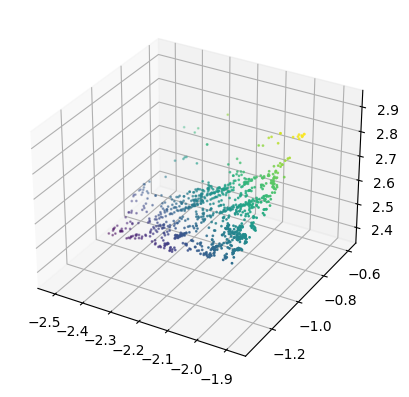

In [15]:
# importing mplot3d toolkits
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()

# syntax for 3-D projection
ax = plt.axes(projection ='3d')

xyz = np.concatenate(depth_gts['xyz'], 0)
xyz.shape

# defining axes
x = depth_gts['xyz'][0][:,0]
y = depth_gts['xyz'][0][:,1]
z = depth_gts['xyz'][0][:,2]
c = x + y
ax.scatter(x, y, z, c = c, s=1)

# syntax for plotting
plt.show()


In [12]:
xyz = np.concatenate(depth_gts['xyz'], 0)
xyz.shape

(206905, 3)